**This file is to train the model and use the trained to test and visualize the performance of prediction (reconstruction).**

In [23]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [1]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import math
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

2024-12-05 03:01:00.535269: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-05 03:01:00.542792: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-05 03:01:00.550845: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-05 03:01:00.553228: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 03:01:00.560122: I tensorflow/core/platform/cpu_feature_guar

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# Local: /Users/FranklinZhao/Research
# SSH: /home/franklin/Research
filepath = "/home/franklin/Research"

def loadTrainingData():

    df_training_data1 = pd.read_csv(f'{filepath}/data_instance_1.csv', skiprows=0)
    df_training_data2 = pd.read_csv(f'{filepath}/data_instance_2.csv', skiprows=0)

    # df_training_data1 = pd.read_csv('drive/MyDrive/OpenSimData/data_instance.csv', skiprows=0)
    # df_training_data2 = pd.read_csv('drive/MyDrive/OpenSimData/data_instance2.csv', skiprows=0)

    # Concatenate all data instances
    X = np.concatenate((df_training_data1.to_numpy(), 
                        df_training_data2.to_numpy()), axis=0)
    
    print("Training Dataset Dimensions: ", X.shape)
    return X

In [3]:
X_augm_train = loadTrainingData()
n_samples = X_augm_train.shape[0]

X_augm_train_kinematics = X_augm_train[:, :19]
X_augm_train_IMU = X_augm_train[:, 19:59]
print("Training Kinematics Dimensions:", X_augm_train_kinematics.shape)
print("Training IMU Dimensions: ", X_augm_train_IMU.shape)

Training Dataset Dimensions:  (12913, 59)
Training Kinematics Dimensions: (12913, 19)
Training IMU Dimensions:  (12913, 40)


In [4]:
epochs = 20000
time_augmentation = "t"       #t, tminus1, tplus1
body_parts = ["Arms", "Torso"]      #Arms, Torso, Legs
masking = False

trial_name = "_".join(body_parts) + f"_{time_augmentation}"
if masking: trial_name += f"_masked"
trial_name += f"_{epochs}"

In [5]:
### train_final_completeloss.py -- core part
def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(1.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(1.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out),  minval=low, maxval=high,  dtype=tf.float64)

class VariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    
    This implementation uses probabilistic encoders and decoders using Gaussian distributions and  
    realized by multi-layer perceptrons. The VAE can be learned end-to-end.
    
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self,sess, network_architecture, transfer_fct=tf.nn.relu,  learning_rate=0.001, batch_size=100, vae_mode=False, vae_mode_modalities=False):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.vae_mode = vae_mode
        self.vae_mode_modalities = vae_mode_modalities
        self.profiler = tf.profiler.Profiler(sess.graph)

        self.n_mc = 4
        self.n_vis = 4

        self.n_input   = network_architecture['n_input']
        self.n_z  = network_architecture['n_z']

        self.x   = tf.placeholder(tf.float64, [None, self.n_input],   name='InputData')
        self.x_noiseless   = tf.placeholder(tf.float64, [None, self.n_input],   name='NoiselessData')
        
        self.layers={}

        self.n_epoch = tf.zeros([],tf.float64)

        # Create autoencoder network
        self._create_network()

        # Define loss function based variational upper-bound and corresponding optimizer
        self._create_loss_optimizer()
       
        # Initializing the tensor flow variables
        init = tf.global_variables_initializer() #tf.initialize_all_variables() # 

        # Launch the session
        self.sess = sess #tf.InteractiveSession()
        self.sess.run(init)

        self.saver = tf.train.Saver()
        
        # Summary monitors
        tf.summary.scalar("loss",self.cost) #tf.summary.FileWriter(logs_path) #
        # tf.summary.scalar("loss_J",self.cost_J)
        self.merged_summary_op = tf.summary.merge_all() #tf.merge_all_summaries()

    def _slice_input(self, input_layer, size_mod):
        slices=[]
        count =0
        for i in range(len(self.network_architecture[size_mod])):
            new_slice = tf.slice(input_layer, [0,count], [self.batch_size,self.network_architecture[size_mod][i]]) # tf.slice(layer_2, [0,200], [105,100])
            count+=self.network_architecture[size_mod][i]
            slices.append(new_slice)
        return slices

    def _create_partial_network(self,name,input_layer):
        with tf.name_scope(name):
            self.layers[name]=[input_layer]
            for i in range(len(self.network_architecture[name])):
                h=tf.Variable(xavier_init(int(self.layers[name][-1].get_shape()[1]), self.network_architecture[name][i]))
                b= tf.Variable(tf.zeros([self.network_architecture[name][i]], dtype=tf.float64))
                layer = self.transfer_fct(tf.add(tf.matmul(self.layers[name][-1],    h), b))
                self.layers[name].append(layer)
            
    def _create_variational_network(self, input_layer, latent_size):
        input_layer_size= int(input_layer.get_shape()[1])
        
        h_mean= tf.Variable(xavier_init(input_layer_size, latent_size))
        h_var= tf.Variable(xavier_init(input_layer_size, latent_size))
        b_mean= tf.Variable(tf.zeros([latent_size], dtype=tf.float64))
        b_var= tf.Variable(tf.zeros([latent_size], dtype=tf.float64))
        mean = tf.add(tf.matmul(input_layer, h_mean), b_mean)
        log_sigma_sq = tf.log(tf.exp(tf.add(tf.matmul(input_layer, h_var), b_var)) + 0.0001 )
        return mean, log_sigma_sq

    def _create_modalities_network(self, names, slices):
        for i in range(len(names)):
            self._create_partial_network(names[i],slices[i])

    def _create_mod_variational_network(self, names, sizes_mod):
                assert len(self.network_architecture[sizes_mod])==len(names)
                sizes=self.network_architecture[sizes_mod]
                self.layers['final_means']=[]
                self.layers['final_sigmas']=[]
                for i in range(len(names)):
                        mean, log_sigma_sq=self._create_variational_network(self.layers[names[i]][-1],sizes[i])
                        self.layers['final_means'].append(mean)
                        self.layers['final_sigmas'].append(log_sigma_sq)
                global_mean=tf.concat(self.layers['final_means'],1)
                global_sigma=tf.concat(self.layers['final_sigmas'],1)
                self.layers["global_mean_reconstr"]=[global_mean]
                self.layers["global_sigma_reconstr"]=[global_sigma]
                return global_mean, global_sigma
                                       
    def _create_network(self):
        # Initialize autoencode network weights and biases
        self.x_noiseless_sliced=self._slice_input(self.x_noiseless, 'size_slices')
        slices=self._slice_input(self.x, 'size_slices')
        self._create_modalities_network(['mod0','mod1'], slices)

        self.output_mod = tf.concat([self.layers['mod0'][-1],self.layers['mod1'][-1]],1)
        self.layers['concat']=[self.output_mod]
        
        #self._create_partial_network('enc_shared',self.x)
        self._create_partial_network('enc_shared',self.output_mod)
        self.z_mean, self.z_log_sigma_sq = self._create_variational_network(self.layers['enc_shared'][-1],self.n_z)

        if self.vae_mode:
                eps = tf.random_normal((self.batch_size, self.n_z), 0, 1, dtype=tf.float64)
                self.z   = tf.add(self.z_mean, tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))
        else:
                self.z   = self.z_mean

        self._create_partial_network('dec_shared',self.z)

        slices_shared=self._slice_input(self.layers['dec_shared'][-1], 'size_slices_shared')
        self._create_modalities_network(['mod0_2','mod1_2'], slices_shared)

        self.x_reconstr, self.x_log_sigma_sq = self._create_mod_variational_network(['mod0_2','mod1_2'],'size_slices')
                                                                                                                     
    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        with tf.name_scope('Loss_Opt'):
                        self.alpha = 1- tf.minimum(self.n_epoch/1000, 1) # the coefficent used to reduce the impact of latent loss

                        self.tmp_costs=[]
                        for i in range(len(self.layers['final_means'])):
                                reconstr_loss = ( 0.5 * tf.reduce_sum(tf.square(self.x_noiseless_sliced[i] - self.layers['final_means'][i]) / tf.exp(self.layers['final_sigmas'][i]),1) \
                                                + 0.5 * tf.reduce_sum(self.layers['final_sigmas'][i],1) \
                                                + 0.5 * self.n_z/2 * np.log(2*math.pi) )/self.network_architecture['size_slices'][i]
                                self.tmp_costs.append(reconstr_loss)
                                
                        self.reconstr_loss = tf.reduce_mean(self.tmp_costs[0]+ self.tmp_costs[1])

                        self.latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq  - tf.square(self.z_mean)  - tf.exp(self.z_log_sigma_sq), 1)

                        self.cost = tf.reduce_mean(self.reconstr_loss + tf.scalar_mul( self.alpha, self.latent_loss))  # average over batch

                        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)  # Use ADAM optimizer

                        self.m_reconstr_loss = self.reconstr_loss
                        self.m_latent_loss = tf.reduce_mean(self.latent_loss)         

    def print_layers_size(self):
        print(self.cost)
        for layer in self.layers:
            print(layer)
            for l in self.layers[layer]:
                print(l)

    def partial_fit(self,sess, X, X_noiseless, epoch):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """

        opt, cost, recon, latent, x_rec, alpha = sess.run((self.optimizer, self.cost, self.m_reconstr_loss,self.m_latent_loss, self.x_reconstr, self.alpha), 
            feed_dict={self.x: X, self.x_noiseless: X_noiseless, self.n_epoch: epoch})
        return cost, recon, latent, x_rec, alpha

    def transform(self,sess, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively sample from Gaussian distribution
        return sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self,sess, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is generated. Otherwise, z_mu is drawn from prior in latent space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.n_z)
        # Note: This maps to mean of distribution, we could alternatively sample from Gaussian distribution
        return sess.run(self.x_reconstr, feed_dict={self.z: z_mu})
    
    def reconstruct(self,sess, X_test):
        """ Use VAE to reconstruct given data. """
        x_rec_mean,x_rec_log_sigma_sq = sess.run((self.x_reconstr, self.x_log_sigma_sq), 
            feed_dict={self.x: X_test})
        return x_rec_mean,x_rec_log_sigma_sq


def shuffle_data(x):
    y = list(x)
    np.random.shuffle(y)
    return np.asarray(y)

def train_whole(sess,vae, input_data, learning_rate=0.0001, batch_size=100, training_epochs=10, display_step=200, vae_mode=True, vae_mode_modalities=True):
    print('display_step:' + str(display_step))
    epoch_list = []
    avg_cost_list = []
    avg_recon_list = []    
    avg_latent_list = []

    # Write logs to Tensorboard
    # summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
  
    # Training cycle for whole network
    for epoch in tqdm((range(training_epochs))):
        avg_cost = 0.
        avg_recon = 0.
        avg_latent = 0.
        total_batch = int(n_samples / batch_size)
        
        X_shuffled = shuffle_data(input_data)

        # Loop over all batches
        for i in range(total_batch):

            batch_xs_augmented = X_shuffled[batch_size*i:batch_size*i+batch_size] 
            
            batch_xs   = np.asarray(batch_xs_augmented) # augmented (masked) data
            batch_xs_noiseless   = np.asarray(batch_xs_augmented)  # target data
            
            # Fit training using batch data
            cost, recon, latent, x_rec, alpha = vae.partial_fit(sess, batch_xs, batch_xs_noiseless, epoch)
            avg_cost += cost / n_samples * batch_size
            avg_recon += recon / n_samples * batch_size
            avg_latent += latent / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            epoch_list.append(epoch)
            avg_cost_list.append(avg_cost)
            avg_recon_list.append(avg_recon)
            avg_latent_list.append(avg_latent)

            print("Epoch: %04d / %04d, Cost= %04f, Recon= %04f, Latent= %04f" % \
                (epoch,training_epochs,avg_cost, avg_recon, avg_latent))
        
                       
    ### Save the trained model
    param_id= 1
    save_path = vae.saver.save(vae.sess, f"{filepath}/MachineLearning/Models1/model_1.ckpt")
    return epoch_list, avg_cost_list, avg_recon_list, avg_latent_list


def network_param():

    # temporal augmentation
    # network_architecture = \
    #                         {'n_input':118,\
    #                           'n_z':100,\
    #                           'size_slices':[38, 80],\
    #                           # BECAREFUL The number of slice should be equal to the number of _mod_ network
    #                           'size_slices_shared':[48, 100],\
    #                           # BECAREFUL The sum of the dimensions of the slices, should be equal to the last dec_shared
    #                           'mod0':[95,48],\
    #                           'mod1':[200,100],\
    #                           'mod0_2':[48,38],\
    #                           'mod1_2':[100,80],\
    #                           'enc_shared':[350],\
    #                           'dec_shared':[350, 148]}

    network_architecture = \
                            {'n_input':59,\
                              'n_z':100,\
                              'size_slices':[19, 40],\
                              # BECAREFUL The number of slice should be equal to the number of _mod_ network
                              'size_slices_shared':[48, 100],\
                              # BECAREFUL The sum of the dimensions of the slices, should be equal to the last dec_shared
                              'mod0':[95,48],\
                              'mod1':[200,100],\
                              'mod0_2':[48,19],\
                              'mod1_2':[100,40],\
                              'enc_shared':[350],\
                              'dec_shared':[350, 148]}

    return network_architecture

In [6]:
## CHANGE SAVE FILE NAME BEFORE RUNNING!!!!
## Set training parameters
learning_rate = 0.00005
batch_size = 1000

# Train Network
print('Train net')
sess = tf.InteractiveSession()

vae_mode=True
vae_mode_modalities=False

reload_modalities=False
reload_shared=False

vae = VariationalAutoencoder(sess,network_param(),  learning_rate=learning_rate,  batch_size=batch_size, vae_mode=vae_mode, vae_mode_modalities=vae_mode_modalities)
# vae.print_layers_size()

epoch_list, avg_cost_list, avg_recon_list, avg_latent_list = train_whole(sess,vae, X_augm_train, training_epochs=epochs,batch_size=batch_size)
sess.close()

Train net


I0000 00:00:1733389269.417813 2929559 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733389269.433438 2929559 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733389269.434914 2929559 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733389269.540719 2929559 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

display_step:200


2024-12-05 03:01:09.802762: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch: 0000 / 20000, Cost= 3.524997, Recon= 3.524746, Latent= 0.000252
Epoch: 0200 / 20000, Cost= 1.070918, Recon= 1.047701, Latent= 0.029022
Epoch: 0400 / 20000, Cost= 1.011789, Recon= 0.931427, Latent= 0.133936
Epoch: 0600 / 20000, Cost= 0.870951, Recon= 0.669172, Latent= 0.504445
Epoch: 0800 / 20000, Cost= 0.499846, Recon= 0.237494, Latent= 1.311761
Epoch: 1000 / 20000, Cost= -0.522971, Recon= -0.522971, Latent= 11.445756
Epoch: 1200 / 20000, Cost= -0.996122, Recon= -0.996122, Latent= 353.721756
Epoch: 1400 / 20000, Cost= -1.267840, Recon= -1.267840, Latent= 512.187562
Epoch: 1600 / 20000, Cost= -1.430738, Recon= -1.430738, Latent= 580.477054
Epoch: 1800 / 20000, Cost= -1.579727, Recon= -1.579727, Latent= 614.953517
Epoch: 2000 / 20000, Cost= -1.697866, Recon= -1.697866, Latent= 639.823775
Epoch: 2200 / 20000, Cost= -1.774976, Recon= -1.774976, Latent= 658.129252
Epoch: 2400 / 20000, Cost= -1.833550, Recon= -1.833550, Latent= 669.545522
Epoch: 2600 / 20000, Cost= -1.879251, Recon= -

In [7]:
#save the stats during training
np.savetxt('avg_cost_list.csv', avg_cost_list)
np.savetxt('avg_recon_list.csv', avg_recon_list)
np.savetxt('avg_latent_list.csv', avg_latent_list)

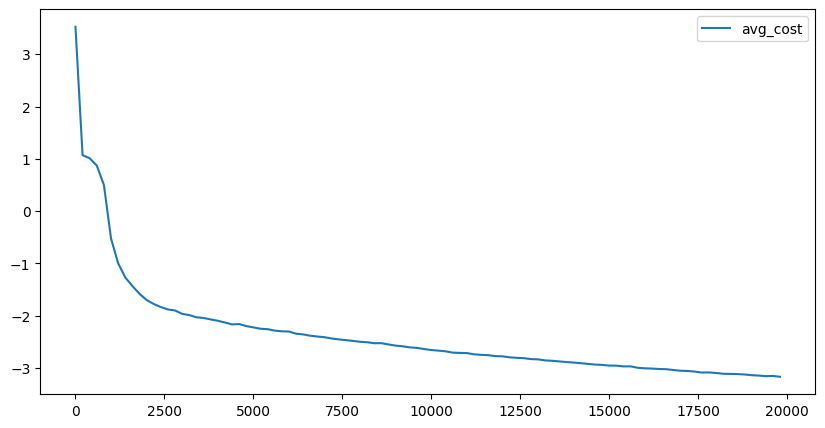

In [8]:
# plot avg cost during training epoches
plt.figure(figsize=(10, 5))
plt.plot(epoch_list, avg_cost_list, label = "avg_cost")
plt.legend()
plt.show()

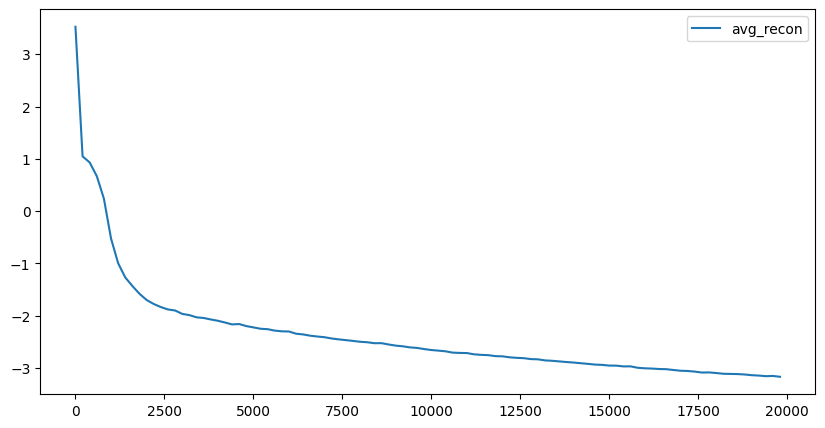

In [9]:
# plot avg reconstruction loss during training epoches
plt.figure(figsize=(10, 5))
plt.plot(epoch_list, avg_recon_list, label = "avg_recon")
plt.legend()
plt.show()

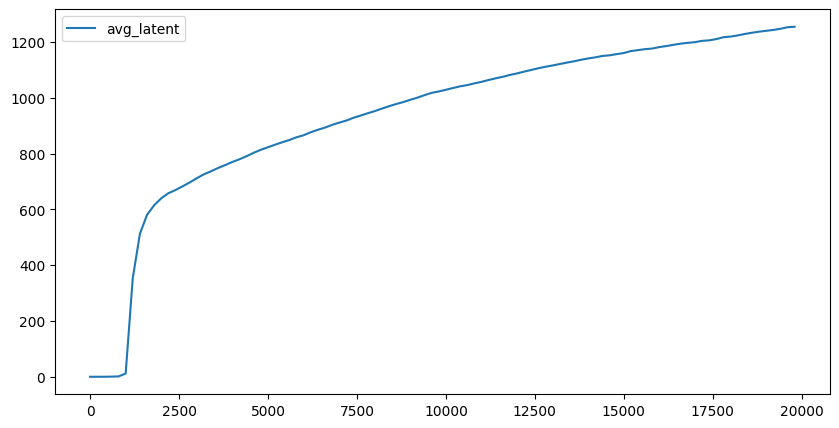

In [10]:
# plot avg latent loss during training epoches
plt.figure(figsize=(10, 5))
plt.plot(epoch_list, avg_latent_list, label = "avg_latent")
plt.legend()
plt.show()

In [11]:
np.std(avg_cost_list)

1.0229934017295146

In [12]:
np.std(avg_recon_list)

1.0062448753356905

In [13]:
np.std(avg_latent_list)

305.08189636970485

In [14]:
##load original dataset as ground true value
df_testing_data = pd.read_csv(f'{filepath}/data_instance_3.csv', skiprows=0)

X_augm_test = df_testing_data.to_numpy()[:, :]
print(X_augm_test.shape)
n_samples = X_augm_test.shape[0]
X_augm_test_kinematics = X_augm_test[:, :19]
print(X_augm_test_kinematics.shape)
X_augm_test_IMU = X_augm_test[:, 19:59]
print(X_augm_test_IMU.shape)

(5202, 59)
(5202, 19)
(5202, 40)


In [15]:
################################################################################################################
## Using the trained model to test the perforamnce of prediction (recontrsuction)
with tf.Graph().as_default() as g:
  with tf.Session() as sess:

      # Network parameters
      network_architecture = network_param()
      print(network_architecture)
      learning_rate = 0.00001
      batch_size = 5202 # use the task one datapoints
      sample_init = 0

      model = VariationalAutoencoder(sess,network_architecture, batch_size=batch_size, learning_rate=learning_rate, vae_mode=False, vae_mode_modalities=False)

  with tf.Session() as sess:
      new_saver = tf.train.Saver()
      param_id= 1
      new_saver.restore(sess, f"{filepath}/MachineLearning/Models1/model_1.ckpt") ###load trained model")
      print("Model restored.")
                        
      ###############################################################################################################
      #Test 1: complete data
      print('Test 1')
      x_reconstruct_1, x_reconstruct_log_sigma_sq_1 = model.reconstruct(sess,X_augm_test)

   

I0000 00:00:1733390499.758004 2929559 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733390499.759070 2929559 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733390499.760014 2929559 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733390499.761380 2929559 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

{'n_input': 59, 'n_z': 100, 'size_slices': [19, 40], 'size_slices_shared': [48, 100], 'mod0': [95, 48], 'mod1': [200, 100], 'mod0_2': [48, 19], 'mod1_2': [100, 40], 'enc_shared': [350], 'dec_shared': [350, 148]}
INFO:tensorflow:Restoring parameters from /home/franklin/Research/MachineLearning/Models1/model_1.ckpt


I0000 00:00:1733390500.207576 2929559 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733390500.208673 2929559 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733390500.209626 2929559 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733390500.210603 2929559 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model restored.
Test 1


In [16]:
print(x_reconstruct_1.shape)
print(X_augm_test_kinematics.shape)
sess.close()

(5202, 59)
(5202, 19)


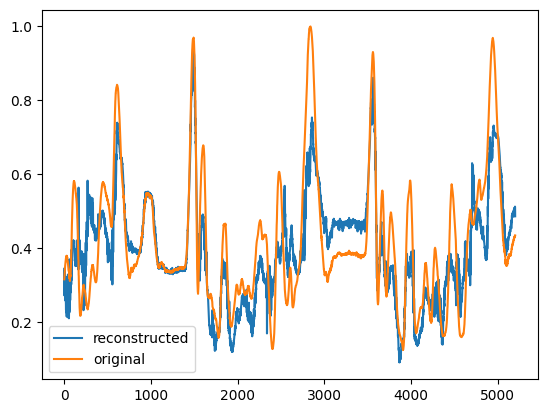

In [17]:
feature = 3
plt.plot(x_reconstruct_1[:, feature], label = "reconstructed")
plt.plot(X_augm_test[:, feature], label = "original")
plt.legend()
plt.show()

In [18]:
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Assuming x_reconstruct_1 and X_augm_test are defined, with the same number of features
# Number of features (change this value based on the actual number of features)
num_features = X_augm_test.shape[1]
# file_path = "plots/{plot_name}.pdf"

# if os.path.isFile(file_path):
#     raise Exception("Dont Overwrite!!!")

# Open a PdfPages object to save plots to a single PDF file
with PdfPages(f"plots/{trial_name}.pdf") as pdf:
    for feature in range(num_features):
        plt.figure()
        plt.plot(x_reconstruct_1[:, feature], label="reconstructed")
        plt.plot(X_augm_test[:, feature], label="original")
        plt.title(f"Feature {feature}")
        plt.legend()
        plt.xlabel("Sample Index")
        plt.ylabel("Feature Value")
        
        # Save the current figure to the PDF
        pdf.savefig()
        plt.close()  # Close the figure after saving it to the PDF to free memory

print("Plots saved!")


Plots saved!


In [19]:
from sklearn.metrics import mean_squared_error
print('reconstruction test')

# 38 for temporal augmentation
# 19 for non temporal augmentation
kinematics_true = X_augm_test[:, :19]
kinematics_pred = x_reconstruct_1[:,:19]
kinematics_mse = mean_squared_error(kinematics_true, kinematics_pred)

IMU_true = X_augm_test[:,19:]
IMU_pred = x_reconstruct_1[:,19:]
IMU_mse = mean_squared_error(IMU_true, IMU_pred)

print(kinematics_mse)
print(IMU_mse)

with open(f"{filepath}/MachineLearning/results/{trial_name}.txt", 'w') as f:
    f.write(f"kinematics MSE: {kinematics_mse}\n")
    f.write(f"IMU MSE: {IMU_mse}\n")

reconstruction test
0.04537713514205135
0.038716339248846945
